In [1]:
import pandas as pd
import datetime
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score,ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [11]:
import pandas as pd
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq
import json
from pandas_gbq import to_gbq

credentials_path = '../../token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [3]:
cri_compustat_merged = pd.read_pickle("cri_compustat_merged_v8.pkl")
cri_compustat_merged.head()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,42404,2000.0,1,0.089239,0.011089,0.677551,0.332808,1.411466,0.027249,-0.148249,...,197946.597222,0.000000,-5.000000,-0.0,1.0,-5.251700e+06,-2.189250e+07,-2.185540e+07,-149041.103448,-297211.000000
1,37610,2000.0,1,0.089239,0.011089,0.087376,-0.524732,0.906364,-0.071829,0.000292,...,190.722132,2.177571,-1.220833,0.0,1.0,2.498284e+01,-7.402171e+01,-6.856532e+01,-0.904380,1.490291
2,49536,2000.0,1,0.313050,0.007314,3.693176,0.625516,1.872712,1.010148,-0.069998,...,0.000000,0.036899,-78.333333,-0.0,1.0,7.542644e+01,-2.309701e+02,-1.503731e+02,-11.081841,-430.222222
3,32417,2000.0,1,0.089239,0.011089,6.165654,0.863910,1.275166,0.184606,0.013360,...,269.176235,0.551135,66.510333,0.0,1.0,5.234158e+01,-2.327468e+01,-1.952816e+01,-395.933333,777.750000
4,44933,2000.0,1,0.089239,0.011089,0.629410,-0.874122,0.000000,0.000000,0.004436,...,0.000000,-2.766467,19.196429,0.0,1.0,7.495250e+01,3.133312e+01,4.316023e+01,0.020216,2.013002


In [8]:
# us = pd.read_csv("y_proba_output(PHD).csv", skiprows=3)

us = read_gbq(f"""

SELECT *
FROM capstone-402105.raw_data.y_proba_output_PHD

""",project_id='capstone-402105', dialect='standard')

In [14]:
# with open('../../token.json', 'r') as token_file:
#     token_data = json.load(token_file)
#     project_id = token_data.get('project_id', 'default-project-id')

# dataset_id = "raw_data"
# table_id = 'cri_compustat_data'

# to_gbq(us, destination_table=f'{project_id}.{dataset_id}.{table_id}', project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 1005.83it/s]


In [15]:
us.rename(columns={'Company_number':'CompNo'}, inplace=True)
us = us.merge(cri_compustat_merged, on=['CompNo','year','month'], how='inner')

#refactor
cols = list(us.columns)

us.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1)
date2020 = datetime.datetime(2020,1,1)
train_df_us = us[us["EventDate"] < date2020]
validation_df_us = us[(us["EventDate"] >= date2020) & (us["EventDate"] < date2022)]
test_df_us = us[us["EventDate"] >= date2022]

train_df_us.drop(["CompNo", "year", "month"], axis=1, inplace=True)
validation_df_us.drop(["CompNo", "year", "month"], axis=1, inplace=True)
test_df_us.drop(["CompNo", "year", "month"], axis=1, inplace=True)

C:\Users\shiho\AppData\Local\Temp\ipykernel_1624\308508092.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_us.drop(["CompNo", "year", "month"], axis=1, inplace=True)
C:\Users\shiho\AppData\Local\Temp\ipykernel_1624\308508092.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df_us.drop(["CompNo", "year", "month"], axis=1, inplace=True)
C:\Users\shiho\AppData\Local\Temp\ipykernel_1624\308508092.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [16]:
x_train_us = train_df_us.drop('Default', axis=1)
y_train_us = train_df_us['Default']
x_validation_us = validation_df_us.drop('Default', axis=1)
y_validation_us = validation_df_us['Default']
x_test_us = test_df_us.drop('Default', axis=1)
y_test_us = test_df_us["Default"]

In [17]:
y_pred_us = x_test_us['12_month']
y_pred_binary_us = np.round(y_pred_us)

Accuracy: 0.9950775517785827
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.9665332567572419


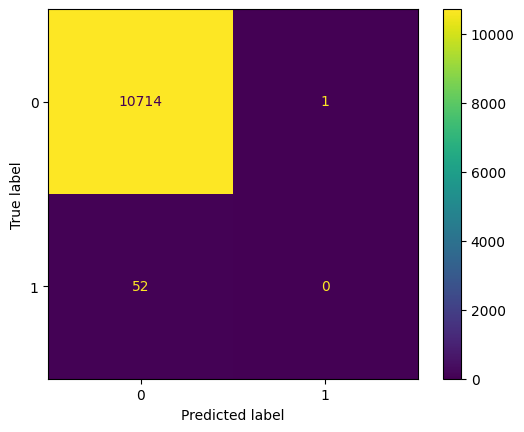

In [18]:
accuracy = accuracy_score(y_test_us, y_pred_binary_us)
recall = recall_score(y_test_us, y_pred_binary_us)
precision = precision_score(y_test_us, y_pred_binary_us)
f1 = f1_score(y_test_us, y_pred_binary_us)
auc = roc_auc_score(y_test_us, y_pred_us)
confusion = confusion_matrix(y_test_us, y_pred_binary_us)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

In [23]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute precision and recall values
precision, recall, _ = precision_recall_curve(y_test_us, y_pred_us)

# Calculate the area under the precision-recall curve (PRAUC)
prauc = auc(recall, precision)

print('PRAUC:', prauc)

ap = average_precision_score(y_test_us, y_pred_us)
print('average_precision_score', ap)

PRAUC: 0.2407548865060661
average_precision_score 0.2509397113149039
